In [160]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

In [161]:

# 1. 加载数据
def load_dataset(path):
    """加载数据集并提取所需信息"""
    data = pd.read_csv(path, header=3)
    timestamp = data.iloc[:, 0].to_numpy()  # 时间戳
    output_voltage = data.iloc[:, 1].to_numpy()
    output_current = data.iloc[:, 2].to_numpy()
    thermistor_temperatures = data.iloc[:, 3:].to_numpy()  # 8个温度传感器数据
    
    return timestamp, output_voltage, output_current, thermistor_temperatures

In [162]:
# 2. 计算传感器位置（单位：cm，转换为与L相同的单位）
def calculate_positions():
    """计算8个温度传感器的位置坐标"""
    L = 0.041  
    bottom_distance = 0.003  
    spacing = 0.005  
    
    positions = []
    for i in range(8):
        pos = bottom_distance + i * spacing
        positions.append(pos)
    
    return np.array(positions)

In [163]:
calculate_positions()

array([0.003, 0.008, 0.013, 0.018, 0.023, 0.028, 0.033, 0.038])

In [164]:
def temperature_model(t, D, C_minus, T0, omega, x):
    
    k = np.sqrt(omega / (2 * D))
    L = 0.041  # 长度，单位m
    C_plus = C_minus * np.exp(2 * L * k * (1 - 1j))
    beta = np.sqrt(omega / (2 * D)) * (1j - 1)  
    term = C_plus * np.exp(beta * x) + C_minus * np.exp(-beta * x)
    fluctuating_temp = np.real(term * np.exp(-1j * omega * t))
    total_temperature = T0 + fluctuating_temp
    
    return total_temperature

In [165]:
def fit_function(t, D, C_minus, T0):
    global current_x
    return temperature_model(t, D, C_minus, T0, omega, current_x)

In [166]:
def fit_diffusivity(timestamp, temperatures, positions):
    results = []
    
    for i, x in enumerate(positions):
        print(f"\nfitting the {i+1} thermometer（{x:.4f}m)")
        global current_x
        current_x = x
        
        T_measured = temperatures[:, i]
        
        initial_guess = [
            3e-5,                # D的初始猜测值（单位：m²/s）
            1.0,                 # C_minus的初始猜测值
            np.mean(T_measured)  # T0的初始猜测值（温度基线）
        ]
        
        bounds = (
            [1e-8, -10.0, np.min(T_measured) - 1],  # 下限：D>0，C_minus可正负，T0不低于测量最小值-1
            [1e-3, 10.0, np.max(T_measured) + 1]    # 上限：D不超过1e-3，T0不高于测量最大值+1
        )
        
        try:
            popt, pcov = curve_fit(
                fit_function, 
                timestamp, 
                T_measured,
                p0=initial_guess,
                bounds=bounds,
                maxfev=20000 
            )
            
            D_fit, C_minus_fit, T0_fit = popt
            
            perr = np.sqrt(np.diag(pcov))
            D_err, C_minus_err, T0_err = perr
            
            results.append({
                'position': x,
                'D': D_fit,
                'D_error': D_err,
                'C_minus': C_minus_fit,
                'C_minus_error': C_minus_err,
                'T0': T0_fit,
                'T0_error': T0_err
            })

            k_fit = np.sqrt(omega / (2 * D_fit))
            L = 0.041  # 长度，单位m
            C_plus_fit = C_minus_fit * np.exp(2 * L * k_fit * (1 - 1j))
            C_plus_err = C_minus_err * np.exp(2 * L * k_fit * (1 - 1j))
            
            print(f"fitting compelete - D = {D_fit:.8f} ± {D_err:.8f} m²/s, "
                  f"C- = {C_minus_fit:.6f} ± {C_minus_err:.6f}, "
                  f"C+ = {C_plus_fit:.6f} ± {C_plus_err:.6f}, "
                  f"T0 = {T0_fit:.4f} ± {T0_err:.4f}"
            )
            
            plot_fit(timestamp, T_measured, x, D_fit, C_minus_fit, T0_fit)
            
        except RuntimeError as e:
            print(f"fit fail: {e}")
            results.append(None)
    
    return results

In [167]:
def plot_fit(t, T_measured, x, D, C_minus, T0):
    
    T_fitted = temperature_model(t, D, C_minus, T0, omega, x)
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, T_measured, 'b.', label='Measured Data')
    plt.plot(t, T_fitted, 'r-', label='Fitted Curve')
    plt.axhline(T0, color='g', linestyle='--', label=f'T0 Baseline = {T0:.4f}')  # Highlight T0
    
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature')
    plt.title(f'Temperature Fit at Position x = {x:.4f} m (period = {period})')
    plt.legend()
    plt.grid(True)
    plt.show()

In [168]:
def analyze_results(results):

    valid_results = [res for res in results if res is not None]
    
    if not valid_results:
        print("No valid fitting results")
        return None
    
    D_values = [res['D'] for res in valid_results]
    D_errors = [res['D_error'] for res in valid_results]
    T0_values = [res['T0'] for res in valid_results]
    T0_errors = [res['T0_error'] for res in valid_results]
    positions = [res['position'] for res in valid_results]
    
    weights_D = 1 / np.square(D_errors)
    D_avg = np.sum(np.array(D_values) * weights_D) / np.sum(weights_D)
    D_avg_unweighted = np.sum(np.array(D_values)) / len(D_values)
    
    weights_T0 = 1 / np.square(T0_errors)
    T0_avg = np.sum(np.array(T0_values) * weights_T0) / np.sum(weights_T0)
    
    print("\n===== Fitting Results Statistics =====")
    print(f"D values at each position: {[f'{d:.8f}' for d in D_values]}")
    print(f"Weighted average of D: {D_avg:.8f} m²/s")
    # print(f"T0 values at each position: {[f'{t:.4f}' for t in T0_values]}")
    # print(f"Weighted average of T0: {T0_avg:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(positions, D_values, yerr=D_errors, fmt='o', color='b', label='D values')
    plt.axhline(D_avg, color='r', linestyle='--', label=f'Avg D = {D_avg:.8f} m²/s')
    plt.xlabel('Position (m)')
    plt.ylabel('Diffusivity D (m²/s)')
    plt.title(f'Fitted Diffusivity Values at Different Positions (period = {period})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {'D_avg': D_avg, 'D_avg_unweighted': D_avg_unweighted, 'T0_avg': T0_avg}


fitting the 1 thermometer（0.0030m)
fitting compelete - D = 0.00001820 ± 0.00000001 m²/s, C- = 0.107095 ± 0.000089, C+ = -3.793699+2.986883j ± -0.003162+0.002490j, T0 = 30.7528 ± 0.0017


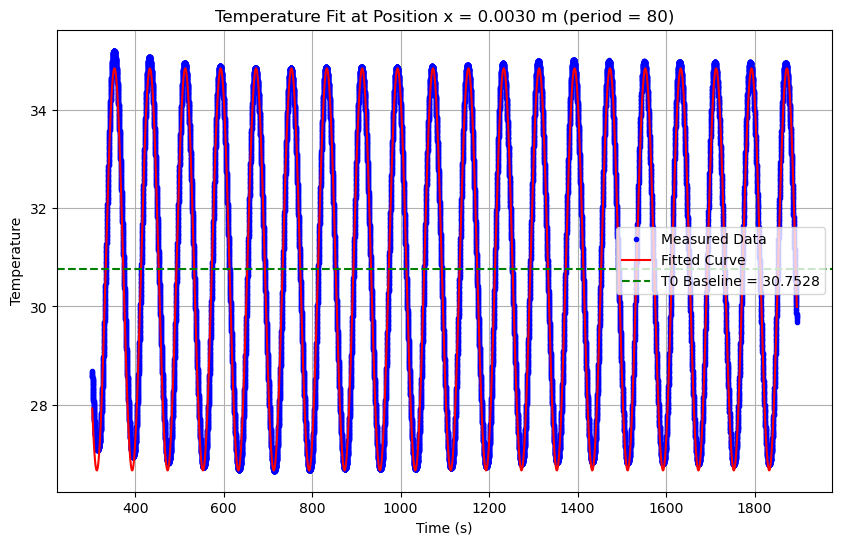


fitting the 2 thermometer（0.0080m)
fitting compelete - D = 0.00001779 ± 0.00000001 m²/s, C- = 0.112243 ± 0.000092, C+ = -4.006916+3.449893j ± -0.003290+0.002832j, T0 = 30.6832 ± 0.0014


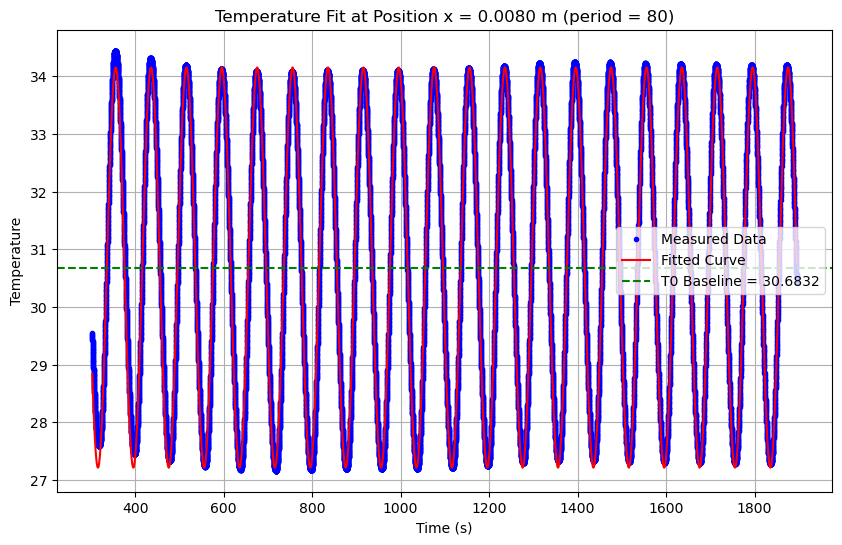


fitting the 3 thermometer（0.0130m)
fitting compelete - D = 0.00001761 ± 0.00000001 m²/s, C- = 0.120975 ± 0.000097, C+ = -4.329246+3.882667j ± -0.003473+0.003115j, T0 = 30.6740 ± 0.0012


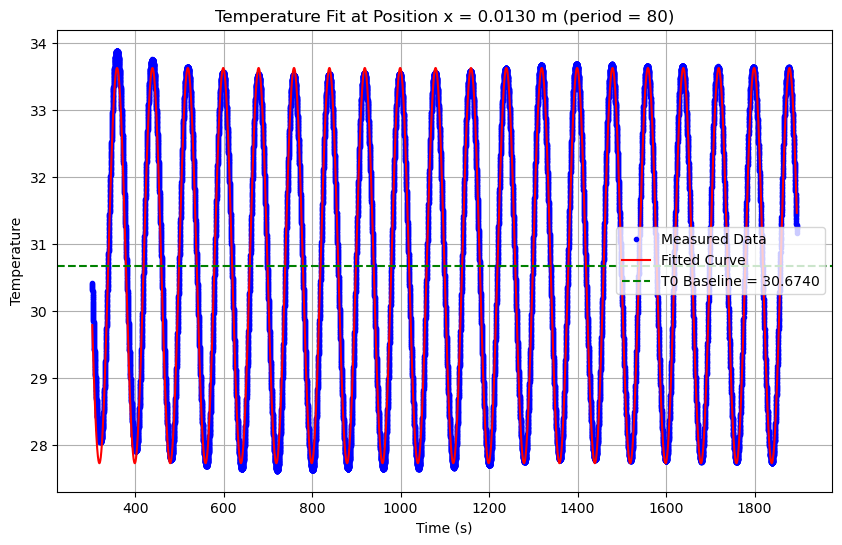


fitting the 4 thermometer（0.0180m)
fitting compelete - D = 0.00001682 ± 0.00000001 m²/s, C- = 0.127447 ± 0.000100, C+ = -4.568157+4.899601j ± -0.003574+0.003833j, T0 = 30.6386 ± 0.0011


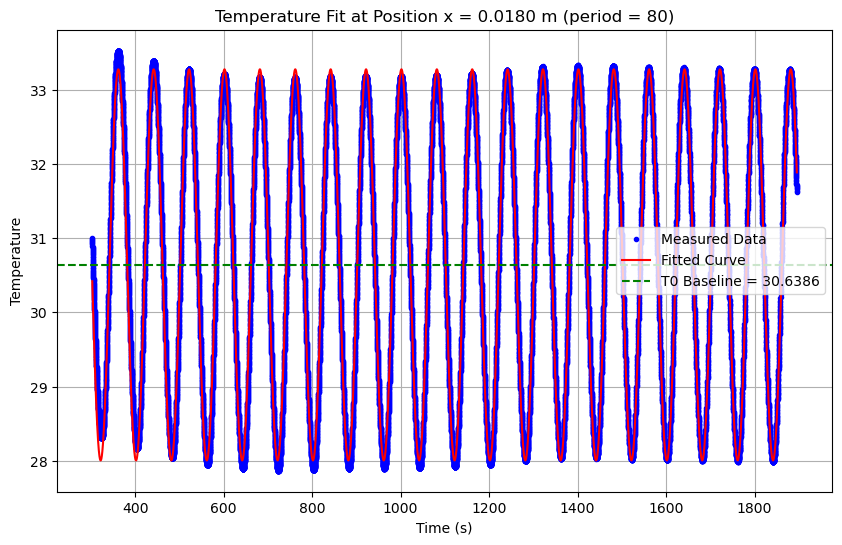


fitting the 5 thermometer（0.0230m)
fitting compelete - D = 0.00001570 ± 0.00000001 m²/s, C- = 0.131295 ± 0.000101, C+ = -4.551581+6.496405j ± -0.003516+0.005018j, T0 = 30.6913 ± 0.0010


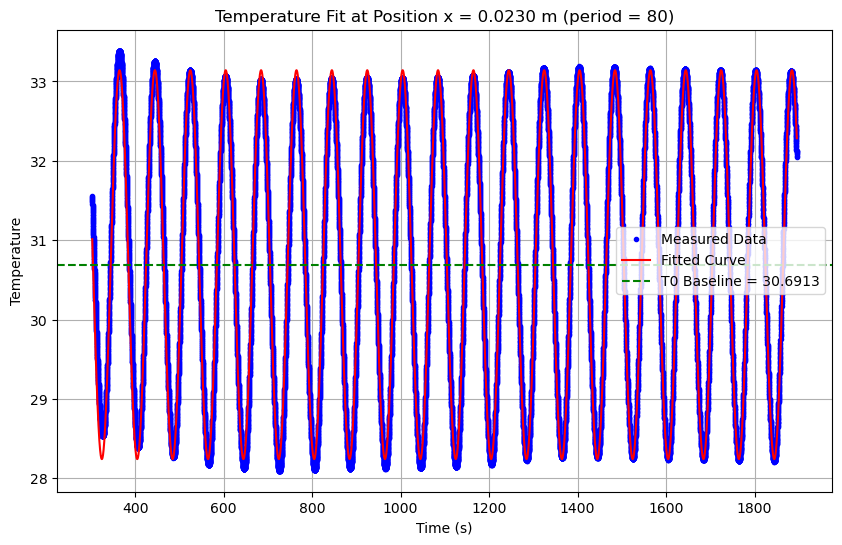


fitting the 6 thermometer（0.0280m)
fitting compelete - D = 0.00001425 ± 0.00000001 m²/s, C- = 0.128378 ± 0.000100, C+ = -3.772282+8.718687j ± -0.002928+0.006767j, T0 = 30.5955 ± 0.0010


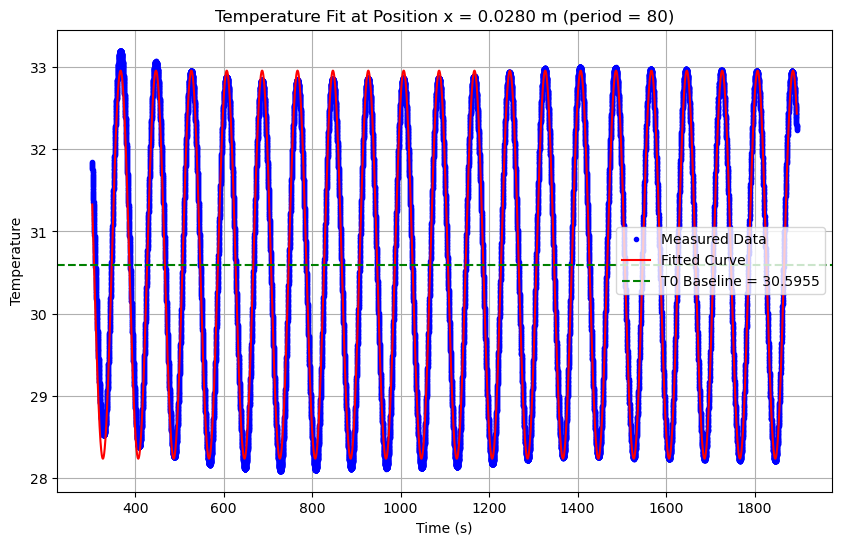


fitting the 7 thermometer（0.0330m)
fitting compelete - D = 0.00001272 ± 0.00000001 m²/s, C- = 0.118009 ± 0.000096, C+ = -1.743141+11.106713j ± -0.001411+0.008990j, T0 = 30.5630 ± 0.0010


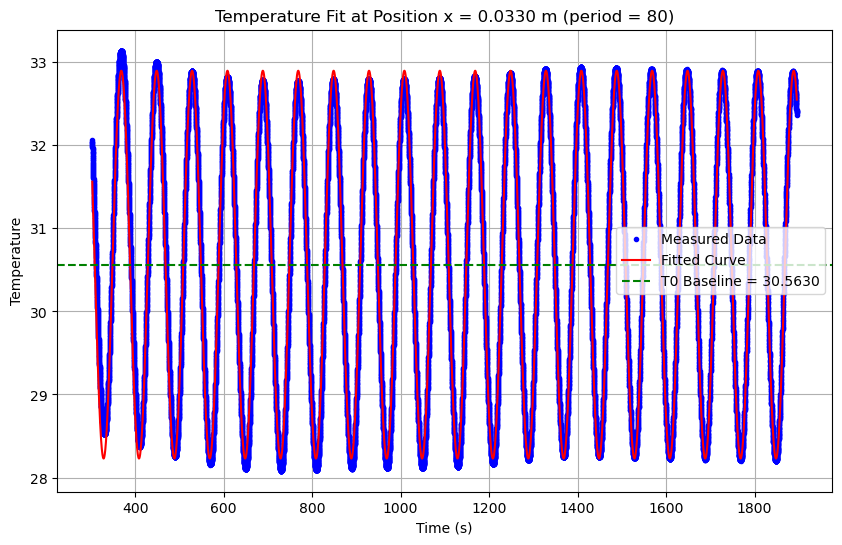


fitting the 8 thermometer（0.0380m)
fitting compelete - D = 0.00001162 ± 0.00000001 m²/s, C- = 0.107276 ± 0.000092, C+ = 0.688221+12.593034j ± 0.000590+0.010789j, T0 = 30.5564 ± 0.0010


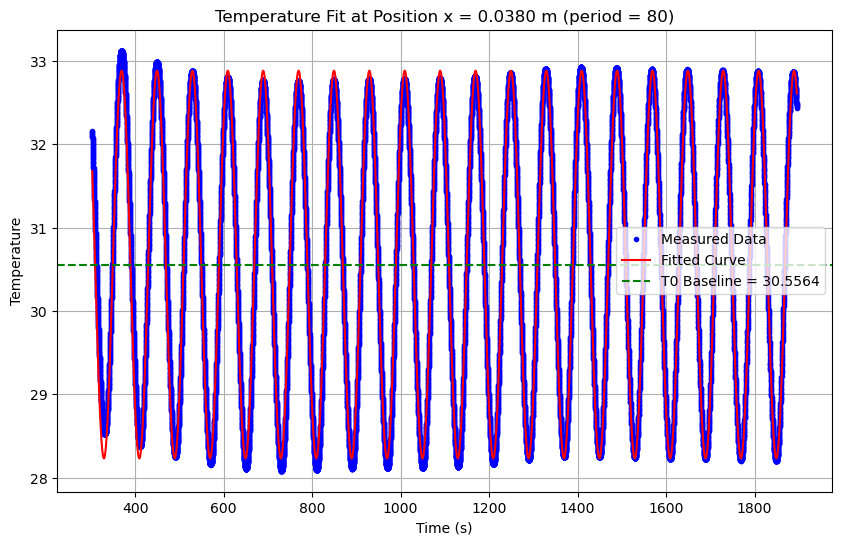


===== Fitting Results Statistics =====
D values at each position: ['0.00001820', '0.00001779', '0.00001761', '0.00001682', '0.00001570', '0.00001425', '0.00001272', '0.00001162']
Weighted average of D: 0.00001561 m²/s
T0 values at each position: ['30.7528', '30.6832', '30.6740', '30.6386', '30.6913', '30.5955', '30.5630', '30.5564']
Weighted average of T0: 30.6284


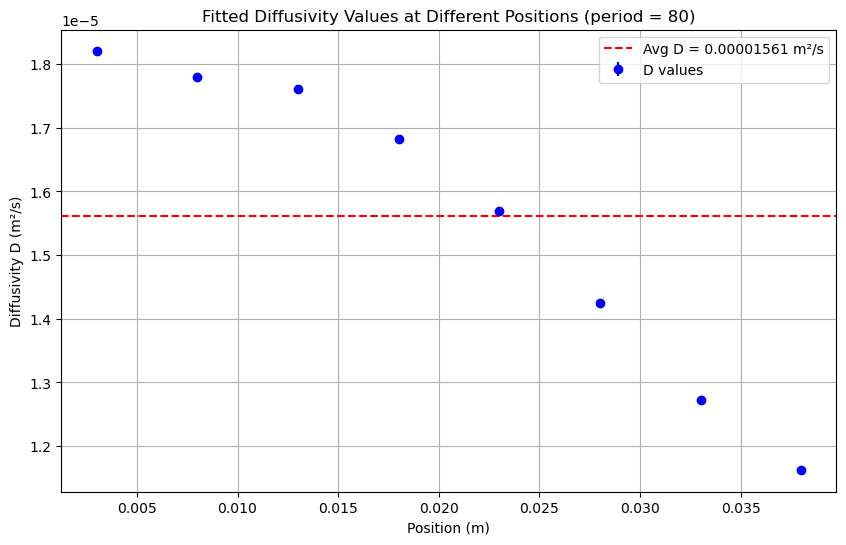


Final average D = 0.00001561 m²/s

Unweighted average D = 0.00001559 m²/s
Final average baseline temperature T0 = 30.6284


In [169]:
period =80
omega = 2*np.pi/period 
if __name__ == "__main__":
    
    timestamp, output_voltage, output_current, thermistor_temperatures = (
        load_dataset("../data/brass data/brass 80s.csv")
    )
    
    positions = calculate_positions()
    
    results = fit_diffusivity(timestamp, thermistor_temperatures, positions)
    
    average_results = analyze_results(results)
    
    if average_results:
        print(f"\nFinal average D = {average_results['D_avg']:.8f} m²/s")
        print(f"\nUnweighted average D = {average_results['D_avg_unweighted']:.8f} m²/s")
        # print(f"Final average baseline temperature T0 = {average_results['T0_avg']:.4f}")


fitting the 1 thermometer（0.0030m)
fitting compelete - D = 0.00002854 ± 0.00000001 m²/s, C- = 0.068896 ± 0.000074, C+ = -2.457773+2.095258j ± -0.002630+0.002242j, T0 = 28.7108 ± 0.0014


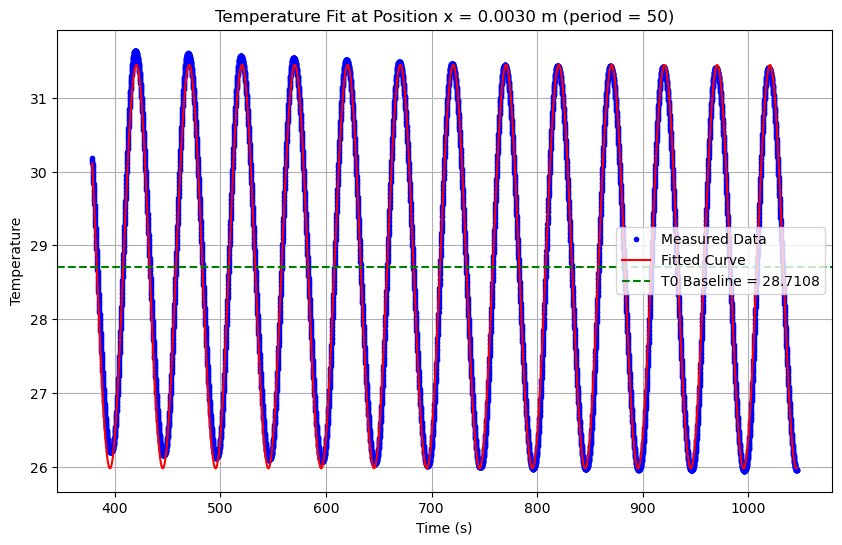


fitting the 2 thermometer（0.0080m)
fitting compelete - D = 0.00002824 ± 0.00000001 m²/s, C- = 0.069585 ± 0.000078, C+ = -2.488941+2.210982j ± -0.002794+0.002482j, T0 = 28.6343 ± 0.0012


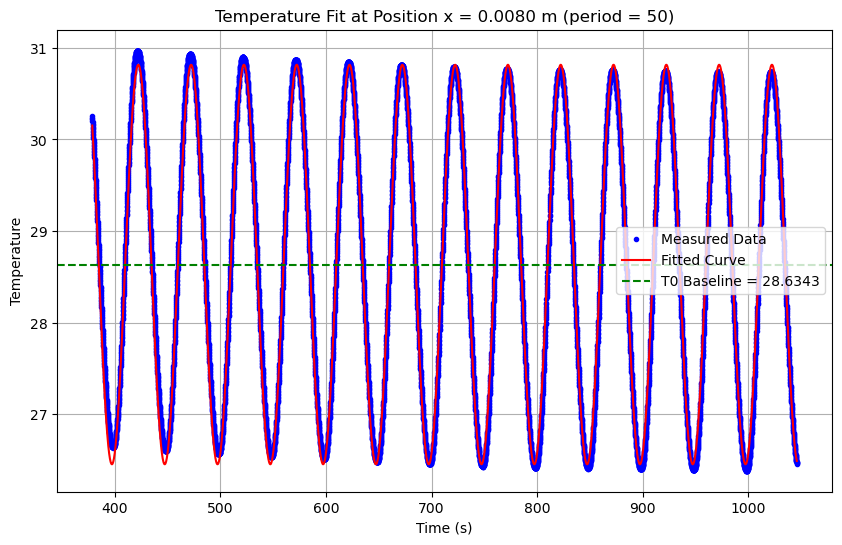


fitting the 3 thermometer（0.0130m)
fitting compelete - D = 0.00002854 ± 0.00000001 m²/s, C- = 0.071540 ± 0.000087, C+ = -2.552163+2.176287j ± -0.003096+0.002640j, T0 = 28.6259 ± 0.0011


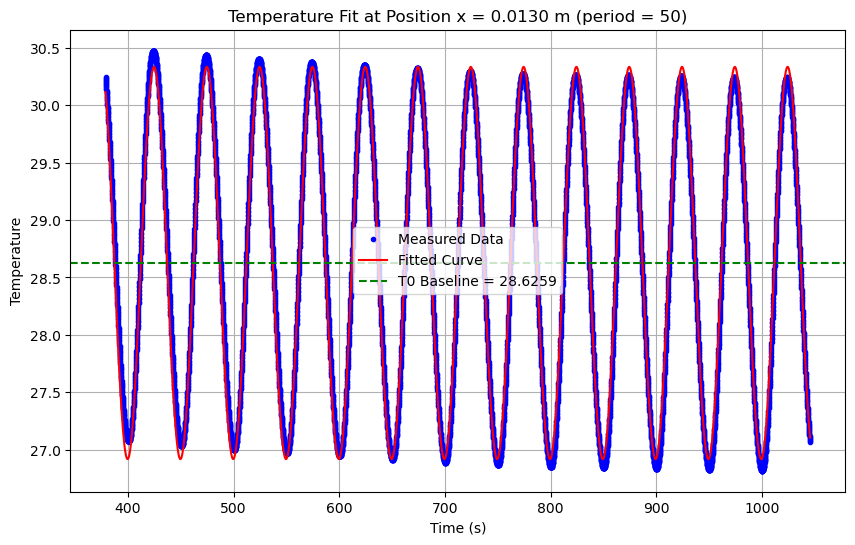


fitting the 4 thermometer（0.0180m)
fitting compelete - D = 0.00002803 ± 0.00000002 m²/s, C- = 0.071799 ± 0.000095, C+ = -2.571790+2.352488j ± -0.003393+0.003104j, T0 = 28.5888 ± 0.0010


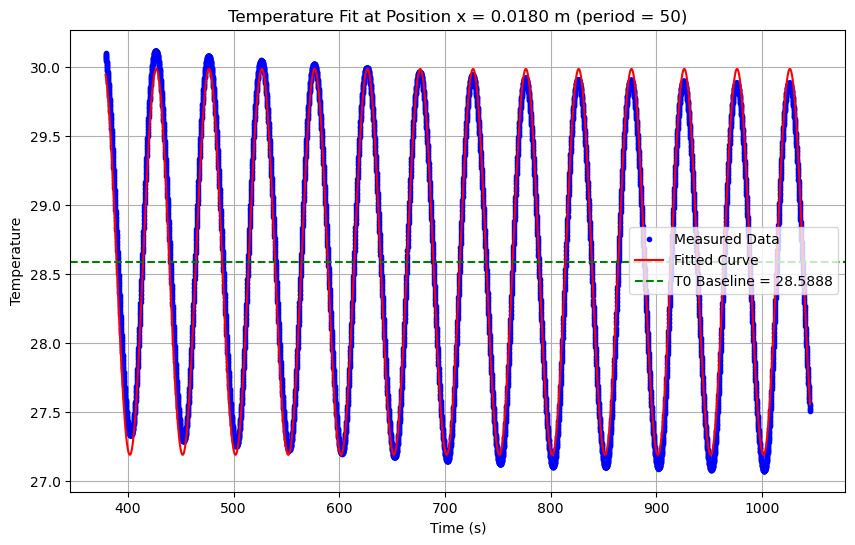


fitting the 5 thermometer（0.0230m)
fitting compelete - D = 0.00002759 ± 0.00000002 m²/s, C- = 0.072878 ± 0.000104, C+ = -2.615013+2.544571j ± -0.003720+0.003619j, T0 = 28.6452 ± 0.0009


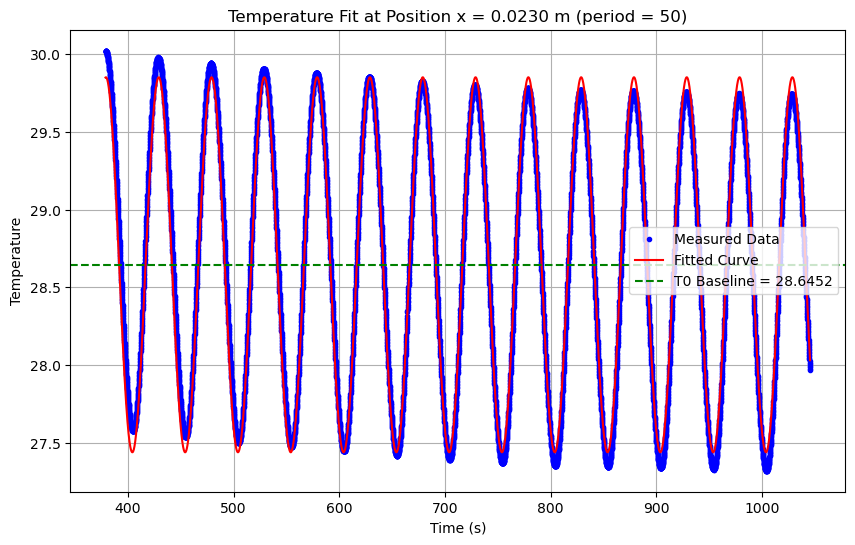


fitting the 6 thermometer（0.0280m)
fitting compelete - D = 0.00002701 ± 0.00000002 m²/s, C- = 0.073056 ± 0.000111, C+ = -2.619781+2.770161j ± -0.003976+0.004204j, T0 = 28.5473 ± 0.0009


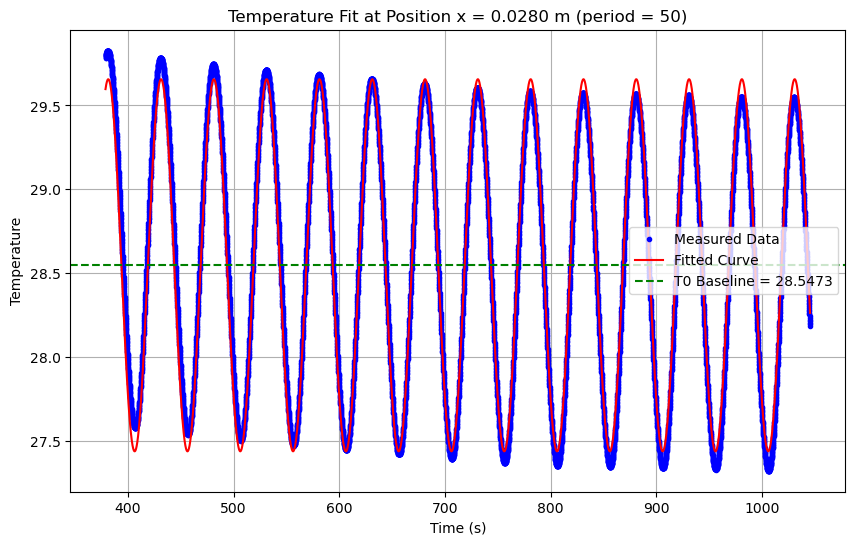


fitting the 7 thermometer（0.0330m)
fitting compelete - D = 0.00002617 ± 0.00000003 m²/s, C- = 0.071589 ± 0.000116, C+ = -2.546610+3.058320j ± -0.004138+0.004970j, T0 = 28.5148 ± 0.0009


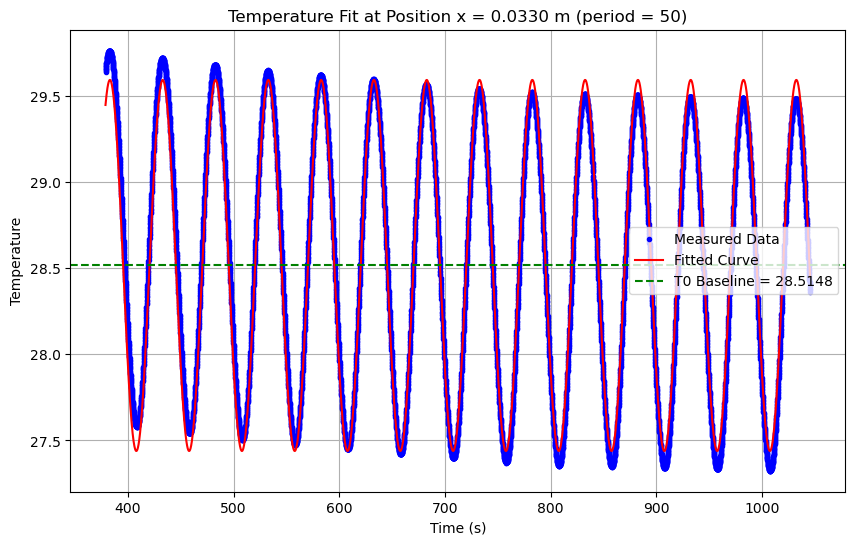


fitting the 8 thermometer（0.0380m)
fitting compelete - D = 0.00002531 ± 0.00000003 m²/s, C- = 0.069377 ± 0.000119, C+ = -2.420503+3.340732j ± -0.004158+0.005739j, T0 = 28.5090 ± 0.0009


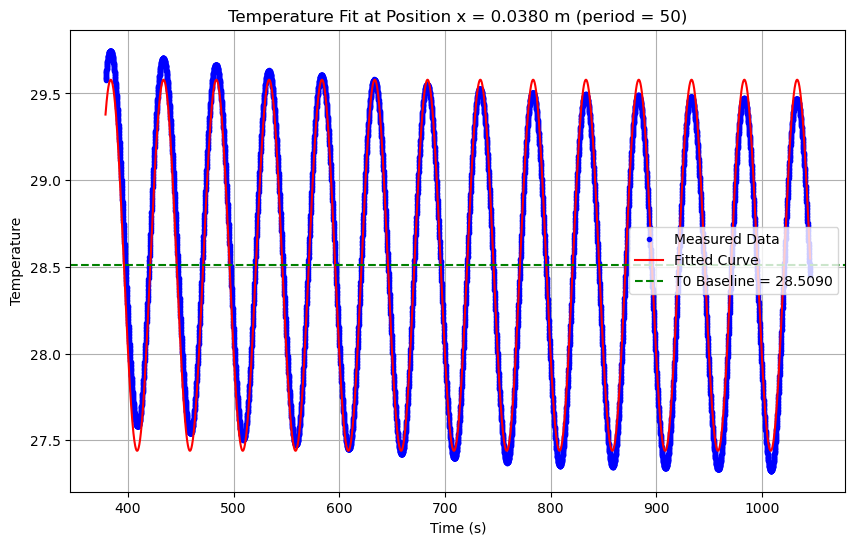


===== Fitting Results Statistics =====
D values at each position: ['0.00002854', '0.00002824', '0.00002854', '0.00002803', '0.00002759', '0.00002701', '0.00002617', '0.00002531']
Weighted average of D: 0.00002801 m²/s
T0 values at each position: ['28.7108', '28.6343', '28.6259', '28.5888', '28.6452', '28.5473', '28.5148', '28.5090']
Weighted average of T0: 28.5835


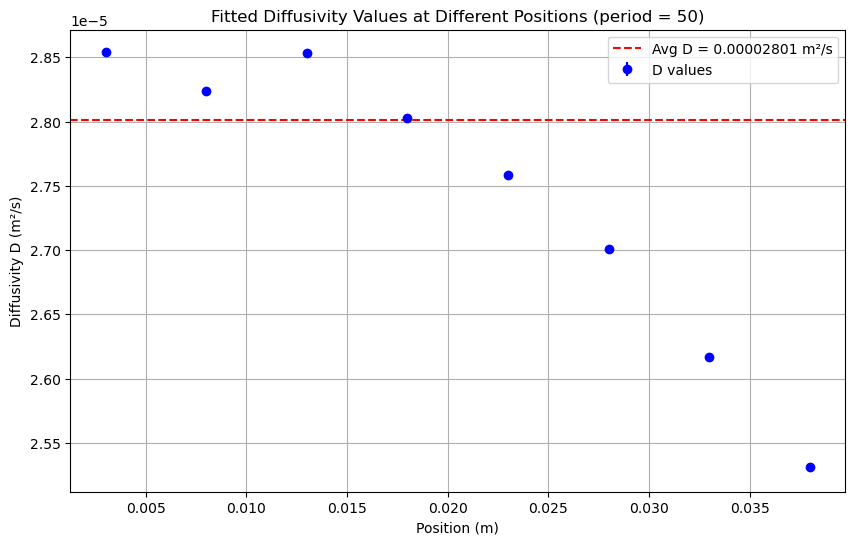


Final average D = 0.00002801 m²/s

Unweighted average D = 0.00002743 m²/s
Final average baseline temperature T0 = 28.5835


In [170]:
period =50
omega = 2*np.pi/period 
if __name__ == "__main__":
    
    timestamp, output_voltage, output_current, thermistor_temperatures = (
        load_dataset("../data/brass data/new brass 50s.csv")
    )
    
    positions = calculate_positions()
    
    results = fit_diffusivity(timestamp, thermistor_temperatures, positions)
    
    average_results = analyze_results(results)
    
    if average_results:
        print(f"\nFinal average D = {average_results['D_avg']:.8f} m²/s")
        print(f"\nUnweighted average D = {average_results['D_avg_unweighted']:.8f} m²/s")
        print(f"Final average baseline temperature T0 = {average_results['T0_avg']:.4f}")


fitting the 1 thermometer（0.0030m)
fitting compelete - D = 0.00002511 ± 0.00000001 m²/s, C- = 0.039031 ± 0.000033, C+ = -1.116020+2.726481j ± -0.000930+0.002271j, T0 = 28.8738 ± 0.0010


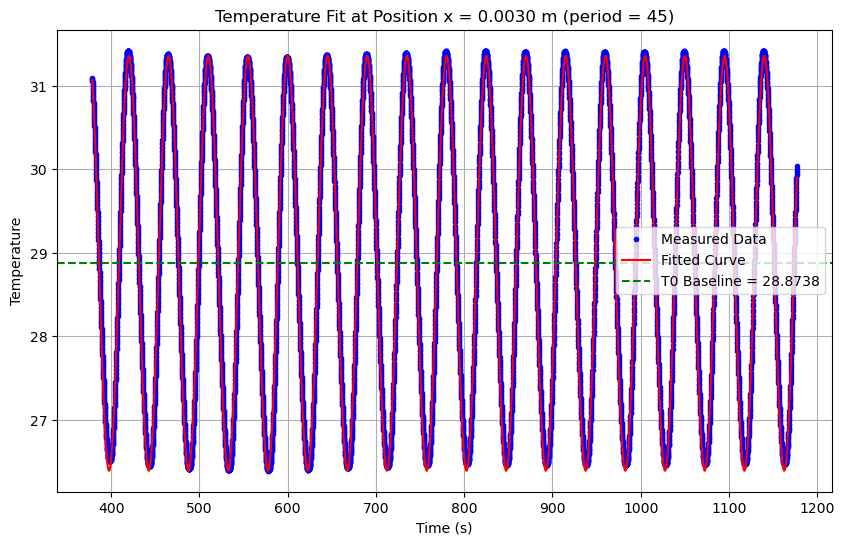


fitting the 2 thermometer（0.0080m)
fitting compelete - D = 0.00002471 ± 0.00000001 m²/s, C- = 0.039492 ± 0.000032, C+ = -1.069542+2.894337j ± -0.000856+0.002316j, T0 = 28.7961 ± 0.0008


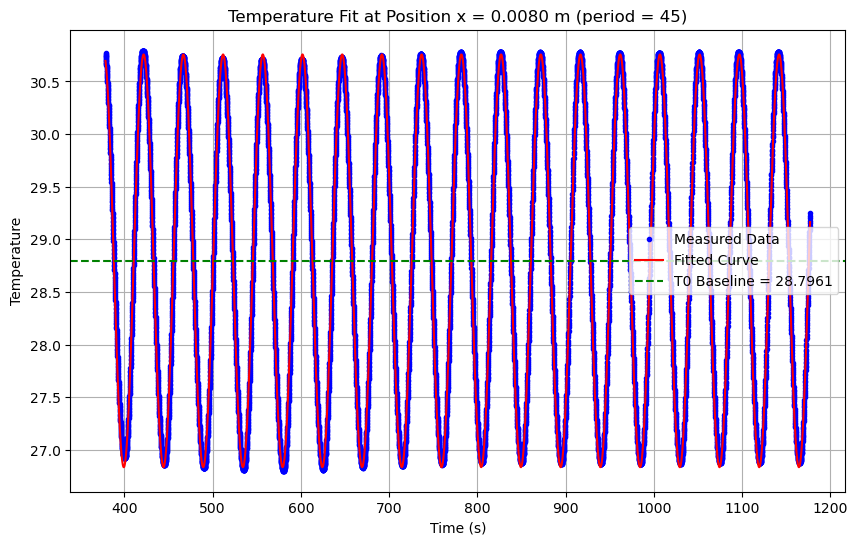


fitting the 3 thermometer（0.0130m)
fitting compelete - D = 0.00002486 ± 0.00000001 m²/s, C- = 0.041060 ± 0.000032, C+ = -1.135976+2.956289j ± -0.000876+0.002281j, T0 = 28.7863 ± 0.0006


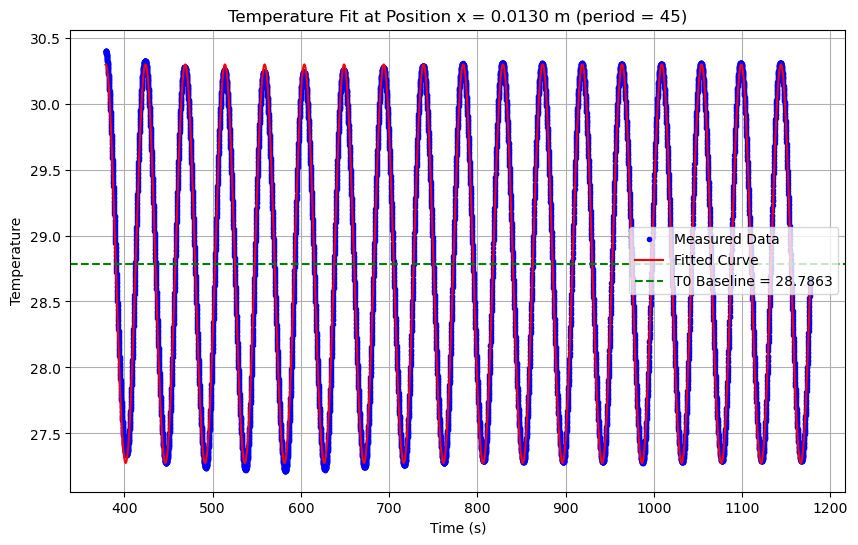


fitting the 4 thermometer（0.0180m)
fitting compelete - D = 0.00002432 ± 0.00000001 m²/s, C- = 0.041909 ± 0.000032, C+ = -1.063486+3.219955j ± -0.000806+0.002441j, T0 = 28.7483 ± 0.0005


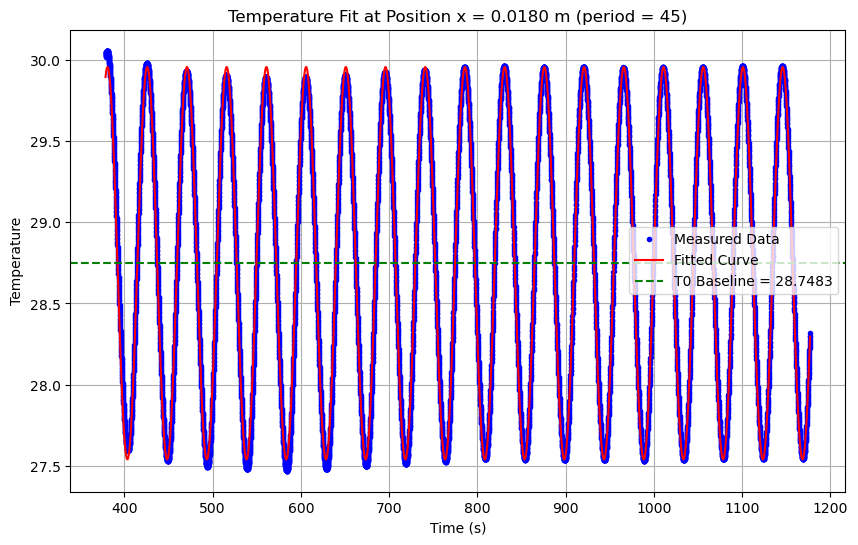


fitting the 5 thermometer（0.0230m)
fitting compelete - D = 0.00002376 ± 0.00000001 m²/s, C- = 0.043545 ± 0.000033, C+ = -0.979958+3.578718j ± -0.000748+0.002731j, T0 = 28.8036 ± 0.0004


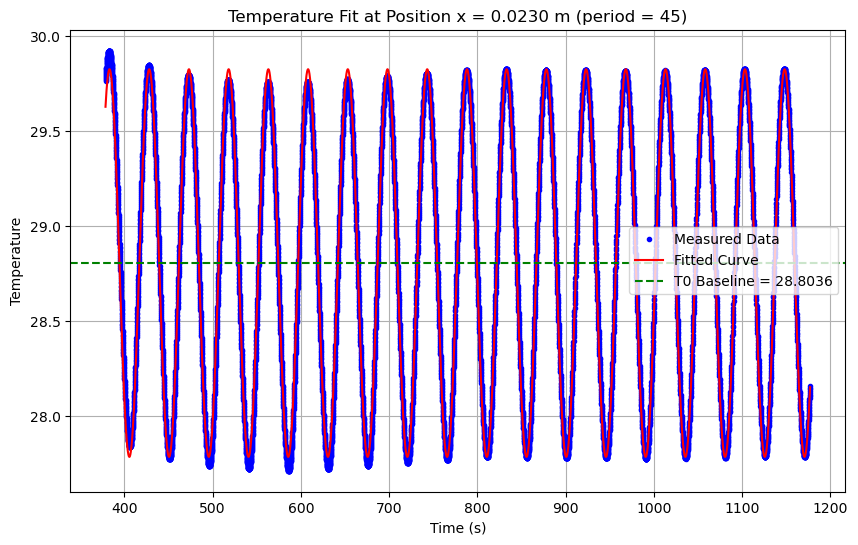


fitting the 6 thermometer（0.0280m)
fitting compelete - D = 0.00002282 ± 0.00000001 m²/s, C- = 0.044028 ± 0.000034, C+ = -0.723586+4.041056j ± -0.000561+0.003132j, T0 = 28.7053 ± 0.0004


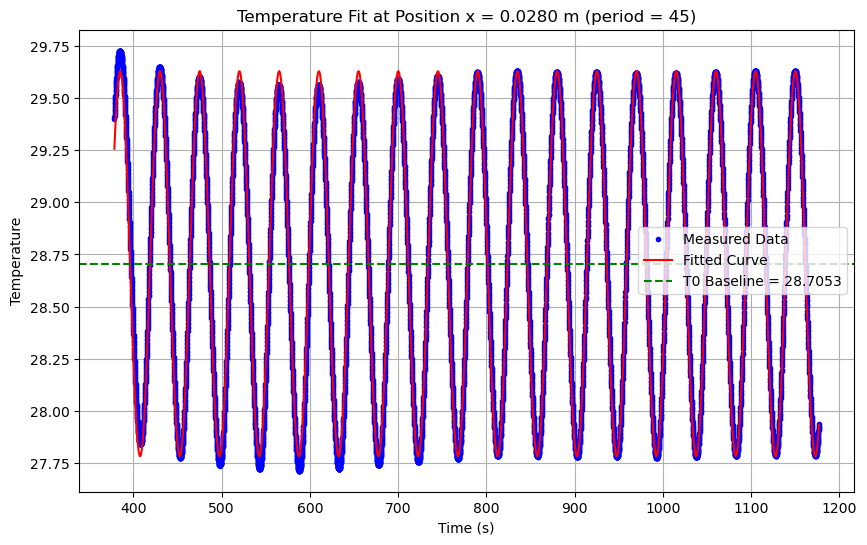


fitting the 7 thermometer（0.0330m)
fitting compelete - D = 0.00002148 ± 0.00000001 m²/s, C- = 0.042350 ± 0.000035, C+ = -0.169328+4.538580j ± -0.000139+0.003729j, T0 = 28.6724 ± 0.0004


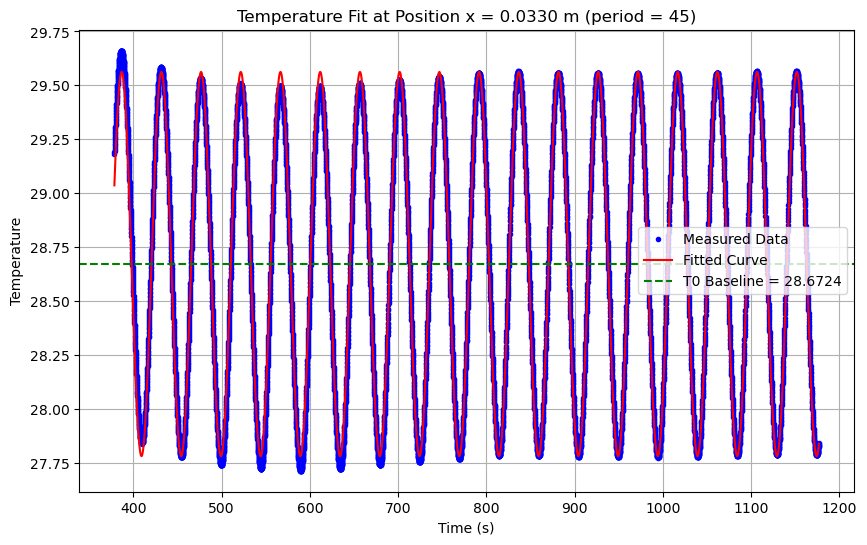


fitting the 8 thermometer（0.0380m)
fitting compelete - D = 0.00002028 ± 0.00000001 m²/s, C- = 0.039860 ± 0.000035, C+ = 0.481667+4.872794j ± 0.000422+0.004273j, T0 = 28.6664 ± 0.0004


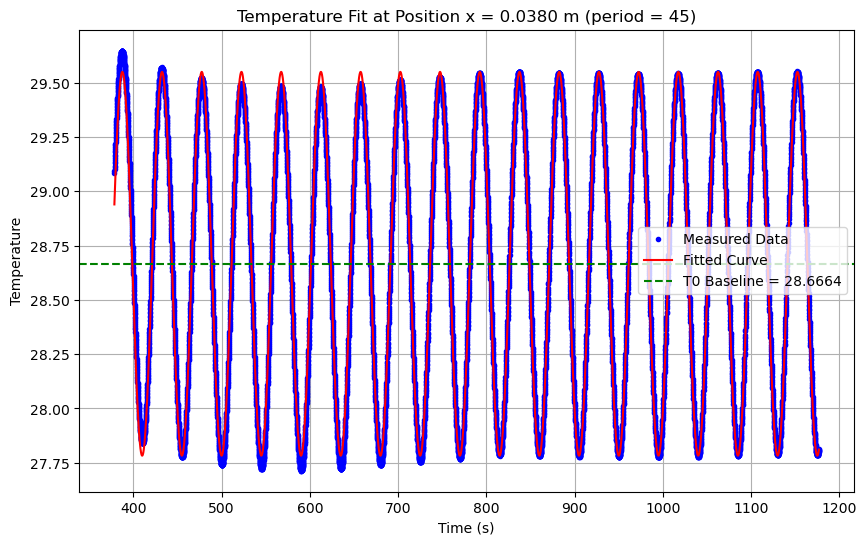


===== Fitting Results Statistics =====
D values at each position: ['0.00002511', '0.00002471', '0.00002486', '0.00002432', '0.00002376', '0.00002282', '0.00002148', '0.00002028']
Weighted average of D: 0.00002384 m²/s
T0 values at each position: ['28.8738', '28.7961', '28.7863', '28.7483', '28.8036', '28.7053', '28.6724', '28.6664']
Weighted average of T0: 28.7284


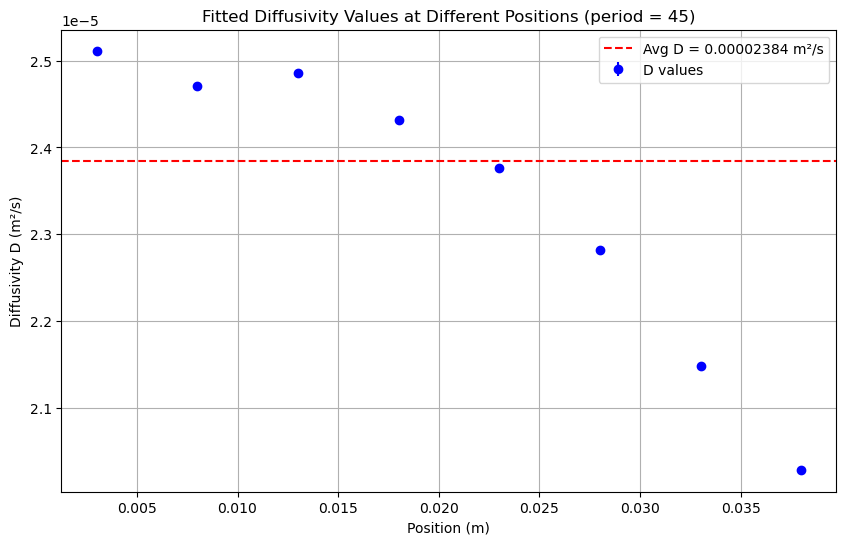


Final average D = 0.00002384 m²/s

Unweighted average D = 0.00002342 m²/s
Final average baseline temperature T0 = 28.7284


In [171]:
period =45
omega = 2*np.pi/period 
if __name__ == "__main__":
    
    timestamp, output_voltage, output_current, thermistor_temperatures = (
        load_dataset("../data/brass data/new brass 45s.csv")
    )
    
    positions = calculate_positions()
    
    results = fit_diffusivity(timestamp, thermistor_temperatures, positions)
    
    average_results = analyze_results(results)
    
    if average_results:
        print(f"\nFinal average D = {average_results['D_avg']:.8f} m²/s")
        print(f"\nUnweighted average D = {average_results['D_avg_unweighted']:.8f} m²/s")
        print(f"Final average baseline temperature T0 = {average_results['T0_avg']:.4f}")


fitting the 1 thermometer（0.0030m)
fitting compelete - D = 0.00003233 ± 0.00000002 m²/s, C- = 0.046235 ± 0.000090, C+ = -1.635895+2.060608j ± -0.003185+0.004012j, T0 = 30.8338 ± 0.0021


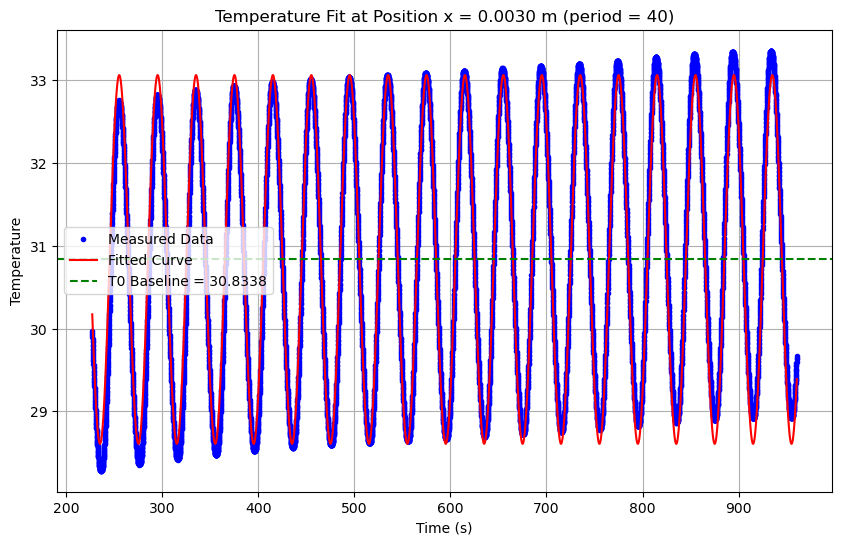


fitting the 2 thermometer（0.0080m)
fitting compelete - D = 0.00003208 ± 0.00000003 m²/s, C- = 0.046428 ± 0.000108, C+ = -1.635413+2.128477j ± -0.003804+0.004950j, T0 = 30.7569 ± 0.0020


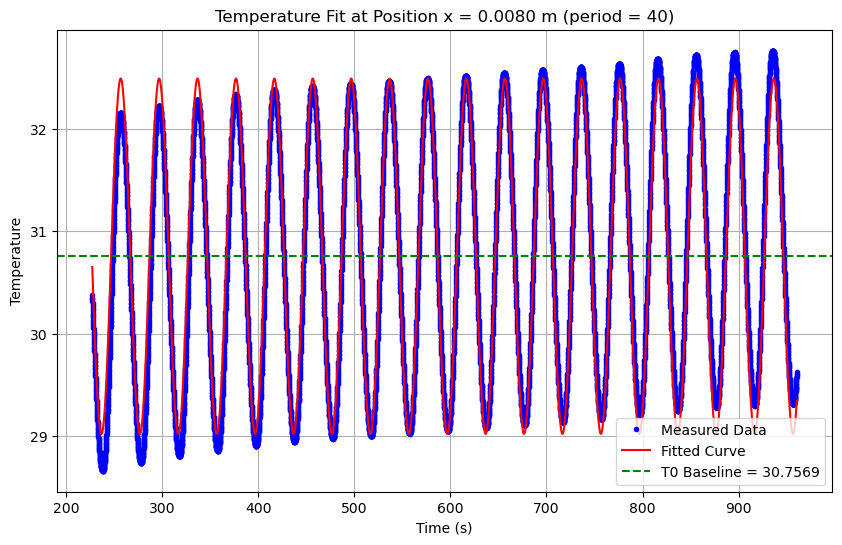


fitting the 3 thermometer（0.0130m)
fitting compelete - D = 0.00003262 ± 0.00000004 m²/s, C- = 0.047279 ± 0.000136, C+ = -1.679884+2.040622j ± -0.004840+0.005879j, T0 = 30.7406 ± 0.0019


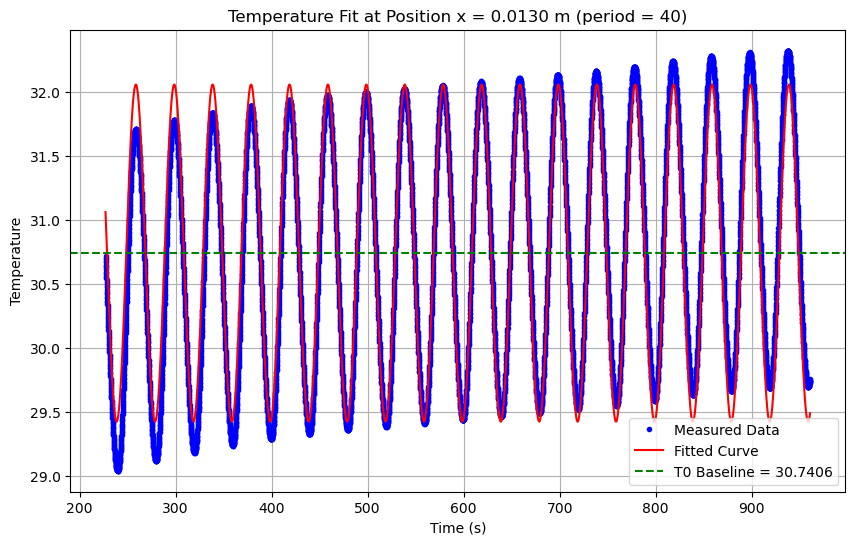


fitting the 4 thermometer（0.0180m)
fitting compelete - D = 0.00003215 ± 0.00000005 m²/s, C- = 0.046492 ± 0.000162, C+ = -1.639730+2.115485j ± -0.005715+0.007374j, T0 = 30.7002 ± 0.0019


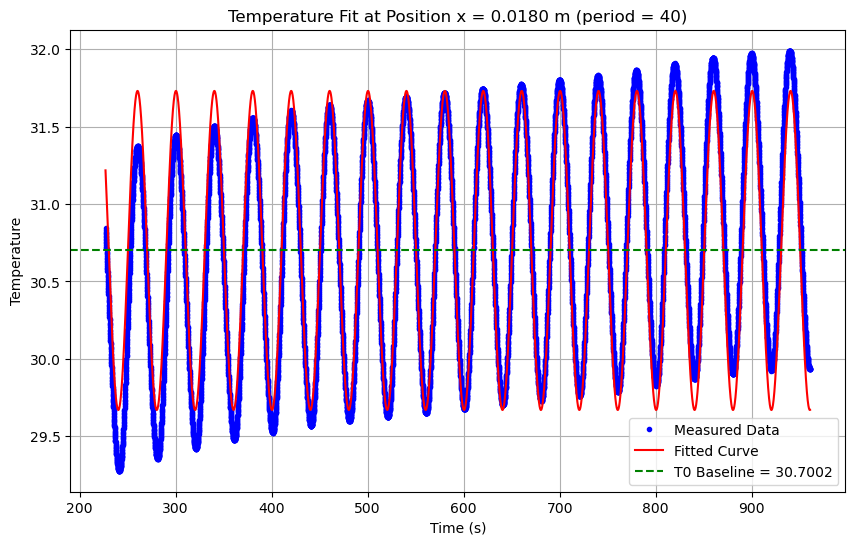


fitting the 5 thermometer（0.0230m)
fitting compelete - D = 0.00003202 ± 0.00000006 m²/s, C- = 0.046590 ± 0.000189, C+ = -1.639215+2.150254j ± -0.006648+0.008721j, T0 = 30.7482 ± 0.0019


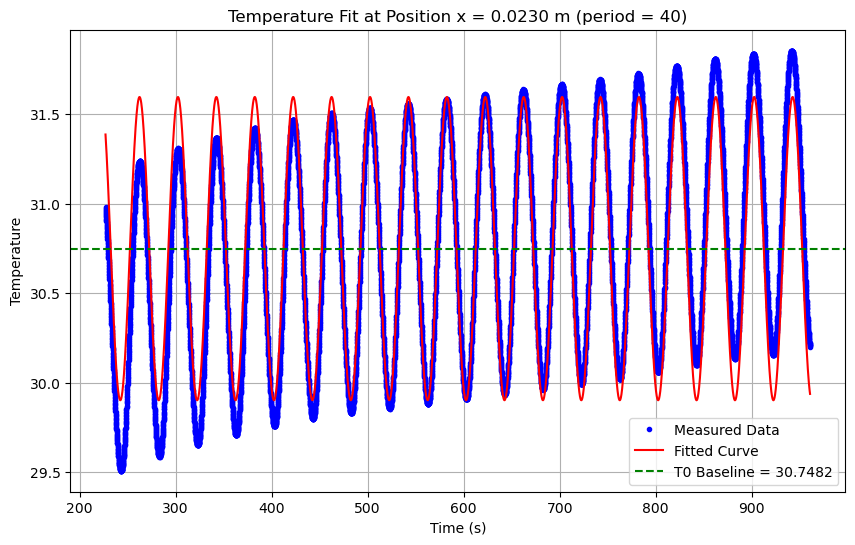


fitting the 6 thermometer（0.0280m)
fitting compelete - D = 0.00003208 ± 0.00000008 m²/s, C- = 0.046706 ± 0.000212, C+ = -1.645095+2.142264j ± -0.007484+0.009746j, T0 = 30.6490 ± 0.0019


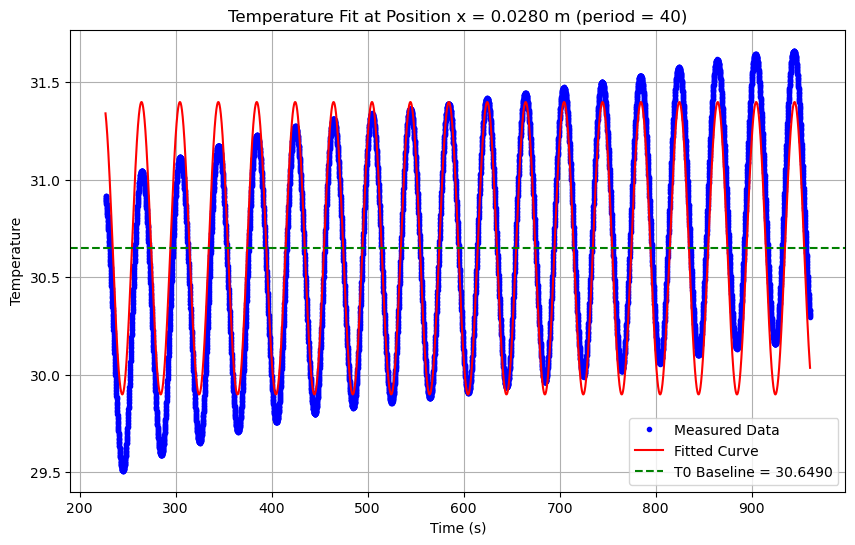


fitting the 7 thermometer（0.0330m)
fitting compelete - D = 0.00003196 ± 0.00000010 m²/s, C- = 0.046464 ± 0.000231, C+ = -1.632735+2.159629j ± -0.008103+0.010718j, T0 = 30.6143 ± 0.0019


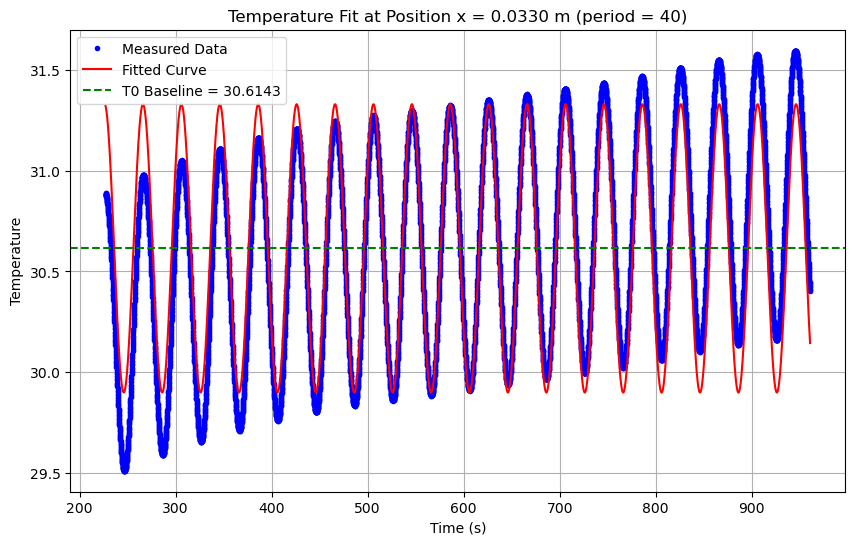


fitting the 8 thermometer（0.0380m)
fitting compelete - D = 0.00003153 ± 0.00000011 m²/s, C- = 0.045791 ± 0.000241, C+ = -1.593206+2.232005j ± -0.008374+0.011731j, T0 = 30.6068 ± 0.0019


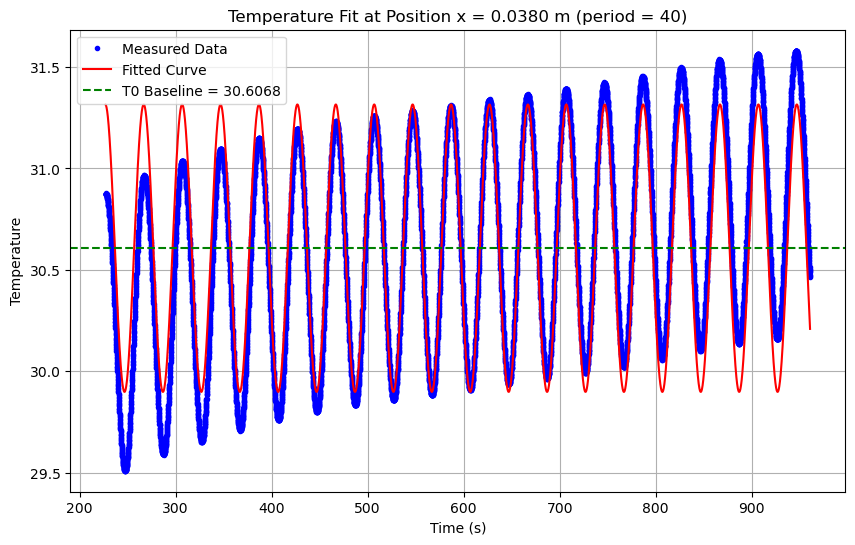


===== Fitting Results Statistics =====
D values at each position: ['0.00003233', '0.00003208', '0.00003262', '0.00003215', '0.00003202', '0.00003208', '0.00003196', '0.00003153']
Weighted average of D: 0.00003225 m²/s
T0 values at each position: ['30.8338', '30.7569', '30.7406', '30.7002', '30.7482', '30.6490', '30.6143', '30.6068']
Weighted average of T0: 30.7016


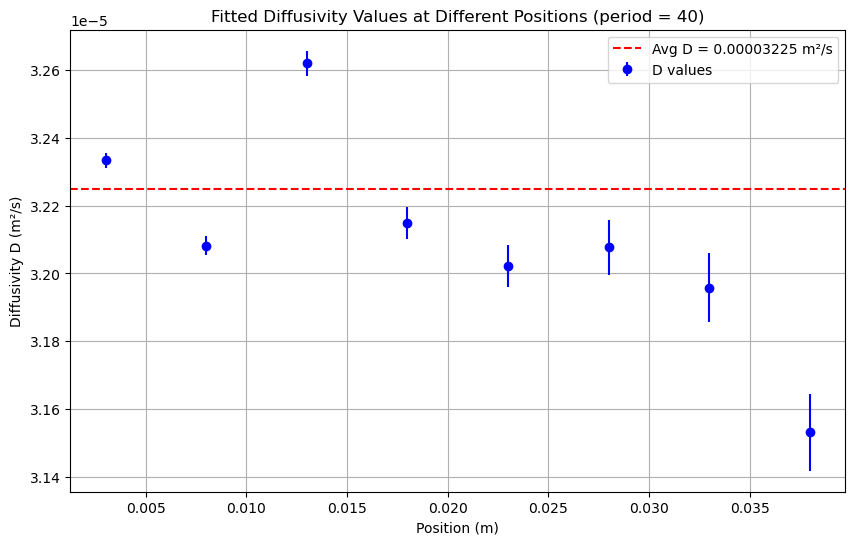


Final average D = 0.00003225 m²/s

Unweighted average D = 0.00003210 m²/s
Final average baseline temperature T0 = 30.7016


In [173]:
period =40
omega = 2*np.pi/period 
if __name__ == "__main__":
    
    timestamp, output_voltage, output_current, thermistor_temperatures = (
        load_dataset("../data/brass data/brass 40s.csv")
    )
    
    positions = calculate_positions()
    
    results = fit_diffusivity(timestamp, thermistor_temperatures, positions)
    
    average_results = analyze_results(results)
    
    if average_results:
        print(f"\nFinal average D = {average_results['D_avg']:.8f} m²/s")
        print(f"\nUnweighted average D = {average_results['D_avg_unweighted']:.8f} m²/s")
        print(f"Final average baseline temperature T0 = {average_results['T0_avg']:.4f}")


fitting the 1 thermometer（0.0030m)
fitting compelete - D = 0.00006045 ± 0.00000002 m²/s, C- = 0.065720 ± 0.000057, C+ = -1.922106+0.535047j ± -0.001667+0.000464j, T0 = 28.1400 ± 0.0007


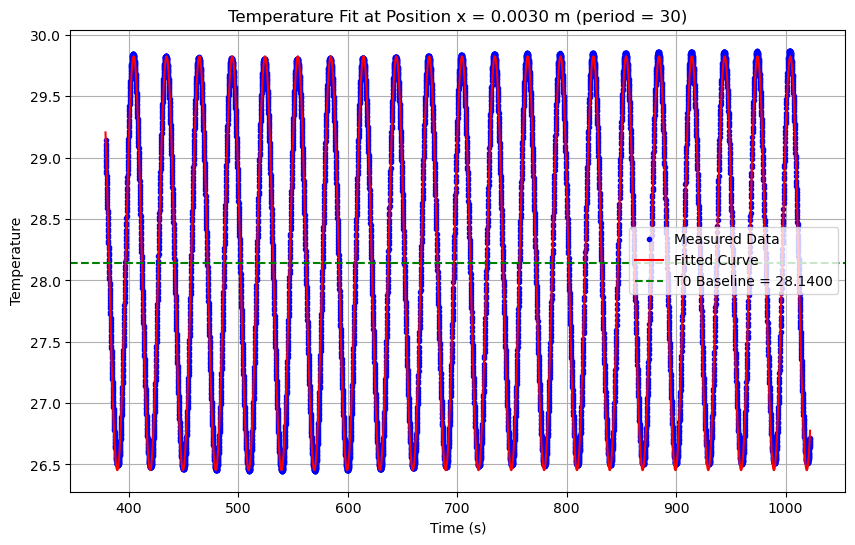


fitting the 2 thermometer（0.0080m)
fitting compelete - D = 0.00006173 ± 0.00000002 m²/s, C- = 0.064227 ± 0.000052, C+ = -1.829307+0.439372j ± -0.001491+0.000358j, T0 = 28.0600 ± 0.0005


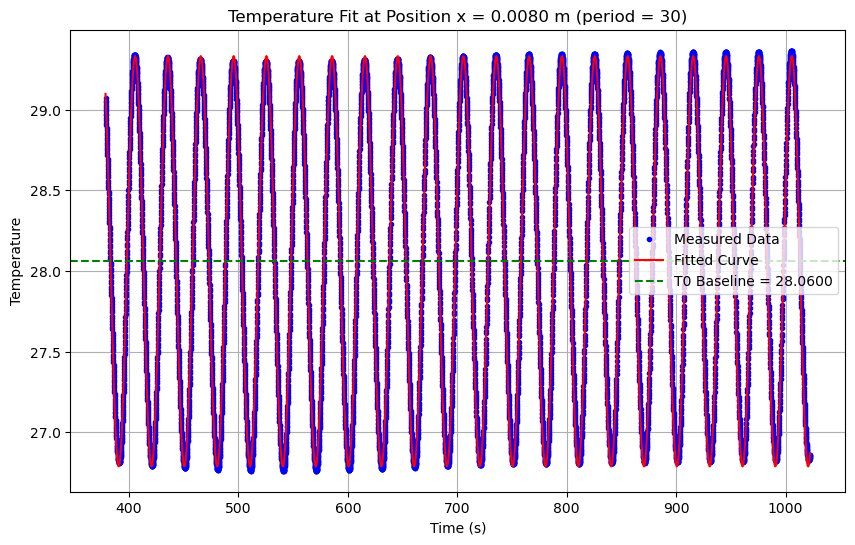


fitting the 3 thermometer（0.0130m)
fitting compelete - D = 0.00006479 ± 0.00000002 m²/s, C- = 0.061283 ± 0.000048, C+ = -1.636294+0.255992j ± -0.001294+0.000202j, T0 = 28.0495 ± 0.0004


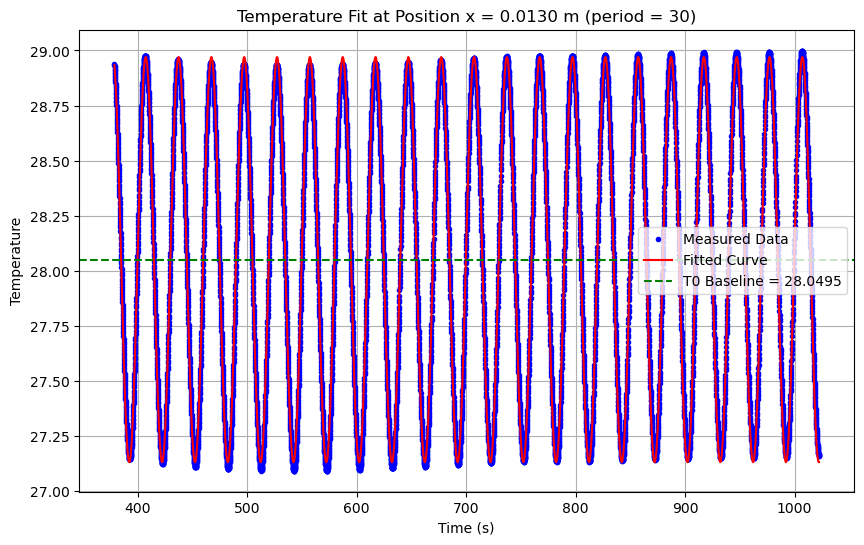


fitting the 4 thermometer（0.0180m)
fitting compelete - D = 0.00006587 ± 0.00000003 m²/s, C- = 0.054780 ± 0.000045, C+ = -1.428910+0.183853j ± -0.001184+0.000152j, T0 = 28.0093 ± 0.0003


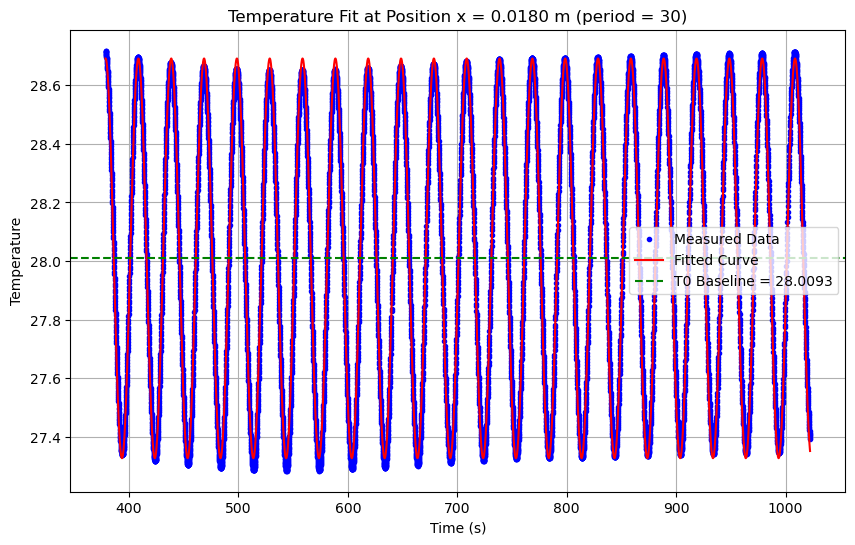


fitting the 5 thermometer（0.0230m)
fitting compelete - D = 0.00007157 ± 0.00000004 m²/s, C- = 0.050709 ± 0.000047, C+ = -1.167674-0.005744j ± -0.001084-0.000005j, T0 = 28.0661 ± 0.0003


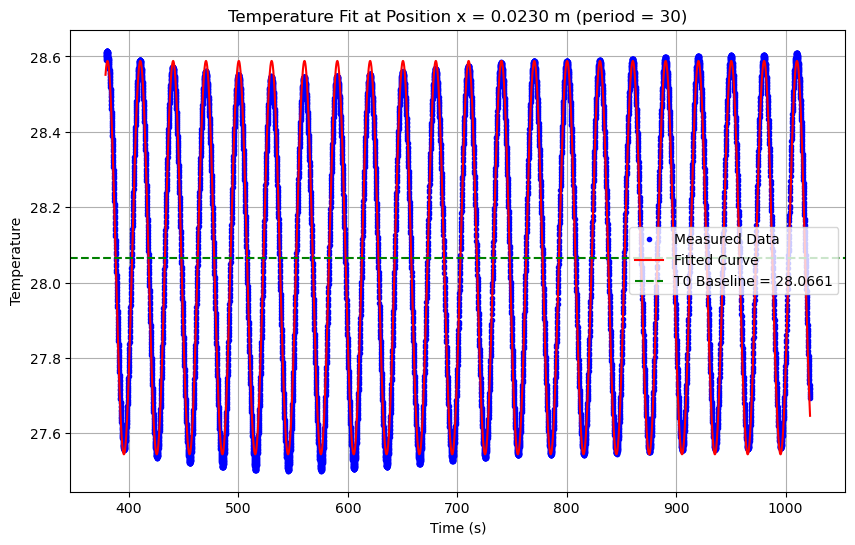


fitting the 6 thermometer（0.0280m)
fitting compelete - D = 0.00008610 ± 0.00000008 m²/s, C- = 0.051092 ± 0.000054, C+ = -0.856790-0.248039j ± -0.000905-0.000262j, T0 = 27.9670 ± 0.0003


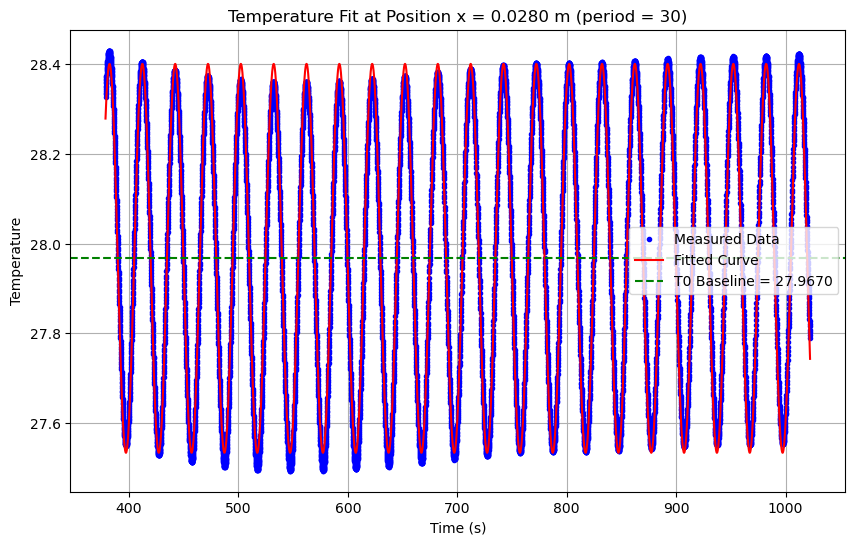


fitting the 7 thermometer（0.0330m)
fitting compelete - D = 0.00011107 ± 0.00000014 m²/s, C- = 0.056833 ± 0.000067, C+ = -0.572161-0.411676j ± -0.000674-0.000485j, T0 = 27.9335 ± 0.0002


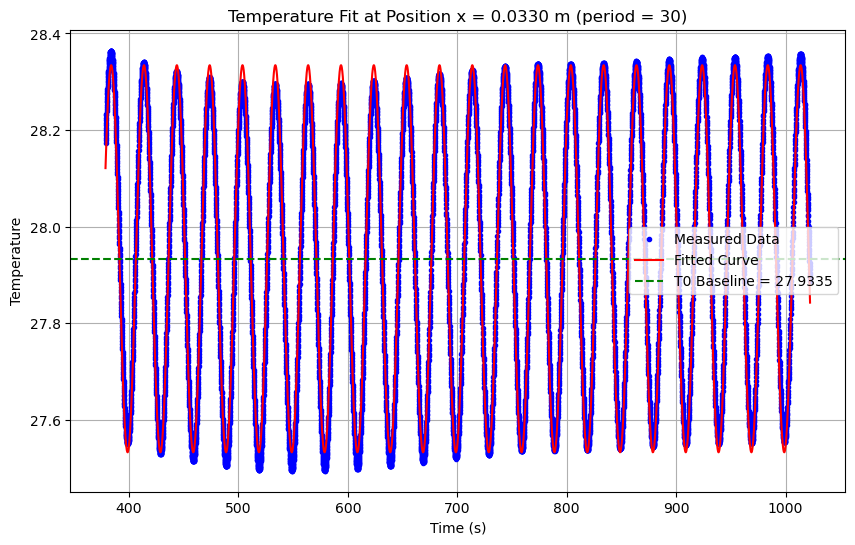


fitting the 8 thermometer（0.0380m)
fitting compelete - D = 0.00013288 ± 0.00000020 m²/s, C- = 0.062547 ± 0.000077, C+ = -0.417372-0.465307j ± -0.000515-0.000574j, T0 = 27.9267 ± 0.0002


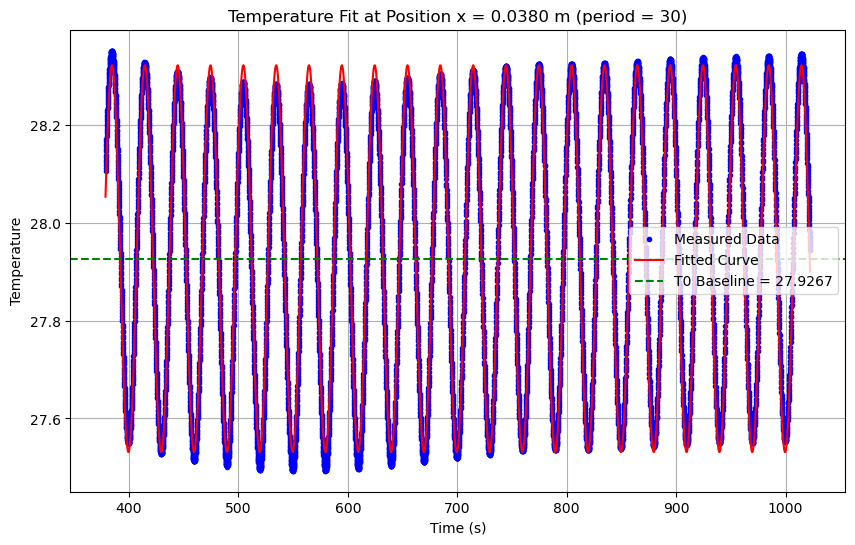


===== Fitting Results Statistics =====
D values at each position: ['0.00006045', '0.00006173', '0.00006479', '0.00006587', '0.00007157', '0.00008610', '0.00011107', '0.00013288']
Weighted average of D: 0.00006437 m²/s
T0 values at each position: ['28.1400', '28.0600', '28.0495', '28.0093', '28.0661', '27.9670', '27.9335', '27.9267']
Weighted average of T0: 27.9875


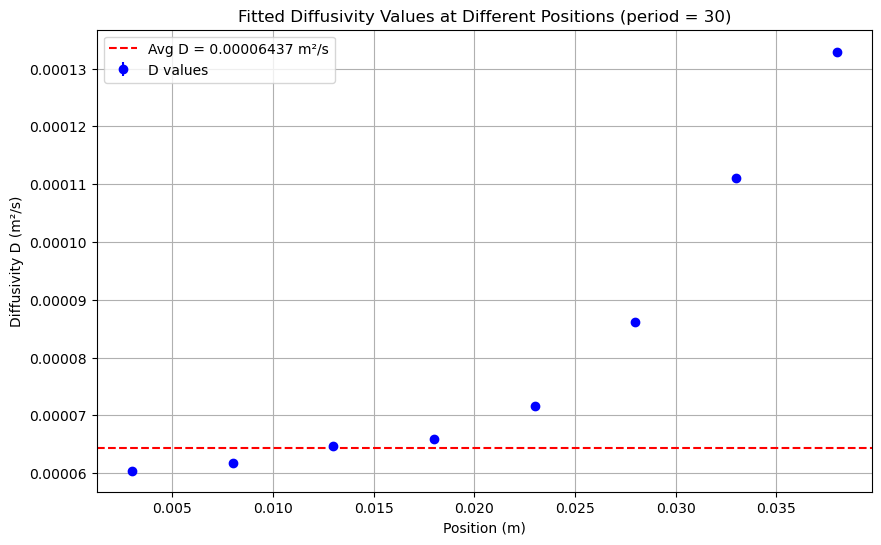


Final average D = 0.00006437 m²/s

Unweighted average D = 0.00008181 m²/s
Final average baseline temperature T0 = 27.9875


In [172]:
period =30
omega = 2*np.pi/period 
if __name__ == "__main__":
    
    timestamp, output_voltage, output_current, thermistor_temperatures = (
        load_dataset("../data/brass data/new brass 30s.csv")
    )
    
    positions = calculate_positions()
    
    results = fit_diffusivity(timestamp, thermistor_temperatures, positions)
    
    average_results = analyze_results(results)
    
    if average_results:
        print(f"\nFinal average D = {average_results['D_avg']:.8f} m²/s")
        print(f"\nUnweighted average D = {average_results['D_avg_unweighted']:.8f} m²/s")
        print(f"Final average baseline temperature T0 = {average_results['T0_avg']:.4f}")


fitting the 1 thermometer（0.0030m)
fitting compelete - D = 0.00002507 ± 0.00000001 m²/s, C- = -0.002131 ± 0.000004, C+ = -1.374107+0.289306j ± 0.002610-0.000550j, T0 = 31.7279 ± 0.0011


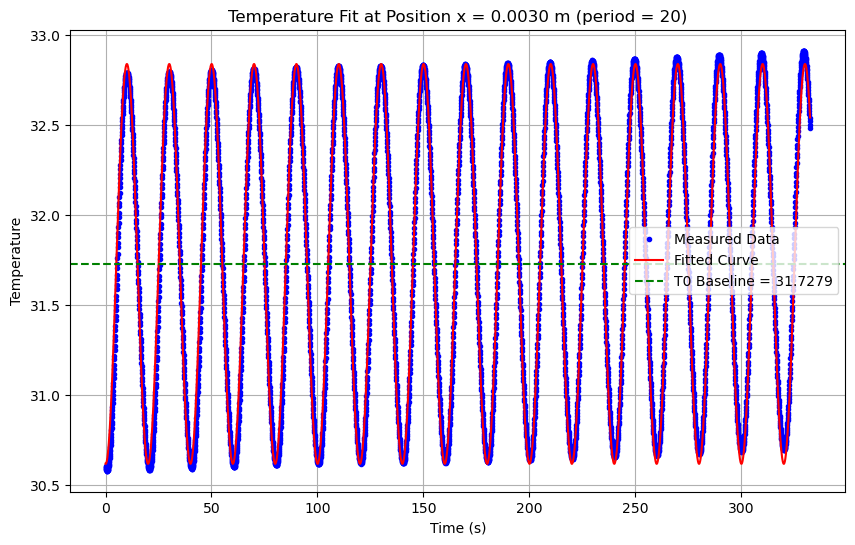


fitting the 2 thermometer（0.0080m)
fitting compelete - D = 0.00002448 ± 0.00000001 m²/s, C- = -0.002126 ± 0.000004, C+ = -1.452540+0.425602j ± 0.002983-0.000874j, T0 = 31.6896 ± 0.0008


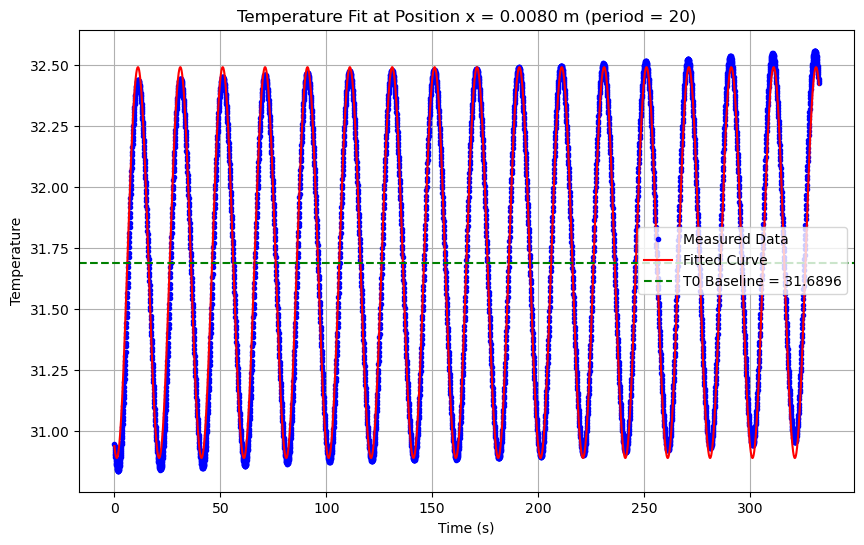


fitting the 3 thermometer（0.0130m)
fitting compelete - D = 0.00002449 ± 0.00000002 m²/s, C- = -0.002167 ± 0.000005, C+ = -1.479720+0.431572j ± 0.003618-0.001055j, T0 = 31.6713 ± 0.0007


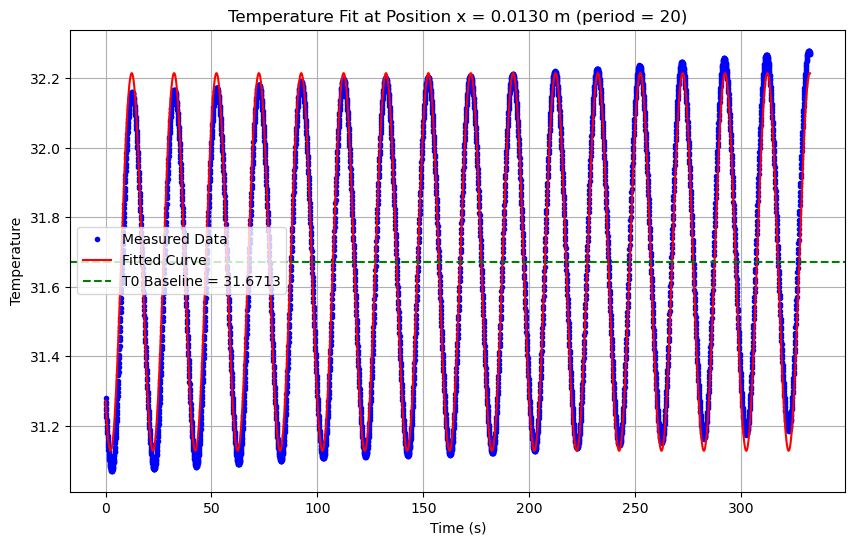


fitting the 4 thermometer（0.0180m)
fitting compelete - D = 0.00002369 ± 0.00000002 m²/s, C- = -0.002102 ± 0.000006, C+ = -1.540792+0.639941j ± 0.004761-0.001977j, T0 = 31.6312 ± 0.0006


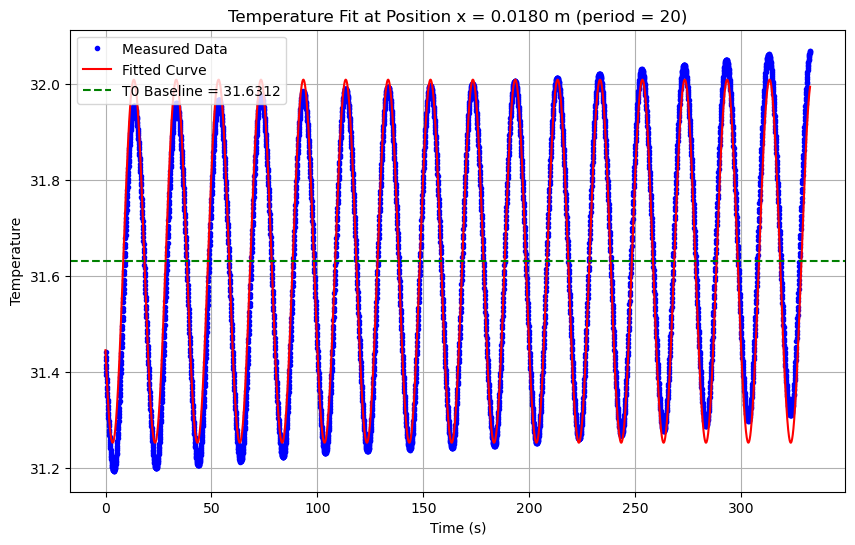


fitting the 5 thermometer（0.0230m)
fitting compelete - D = 0.00002343 ± 0.00000003 m²/s, C- = -0.002197 ± 0.000009, C+ = -1.645197+0.757169j ± 0.006642-0.003057j, T0 = 31.6853 ± 0.0005


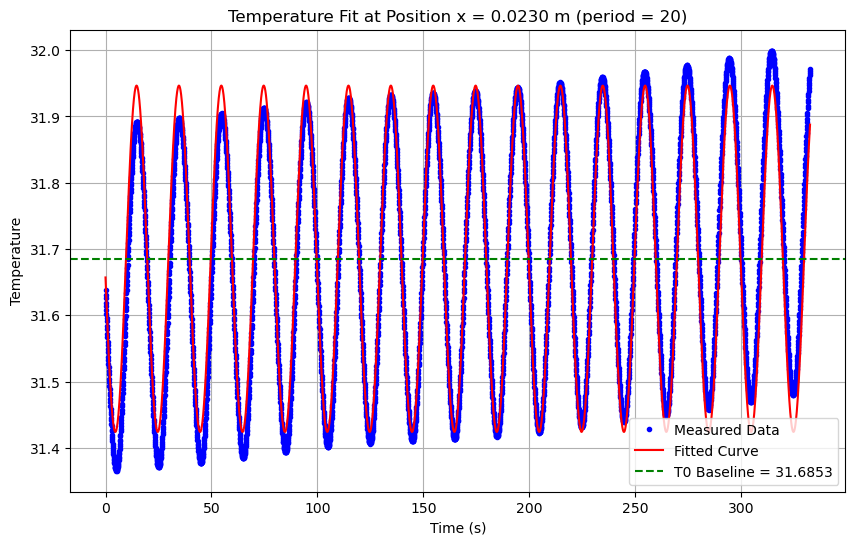


fitting the 6 thermometer（0.0280m)
fitting compelete - D = 0.00002312 ± 0.00000004 m²/s, C- = -0.002364 ± 0.000012, C+ = -1.811190+0.934436j ± 0.009098-0.004694j, T0 = 31.6541 ± 0.0005


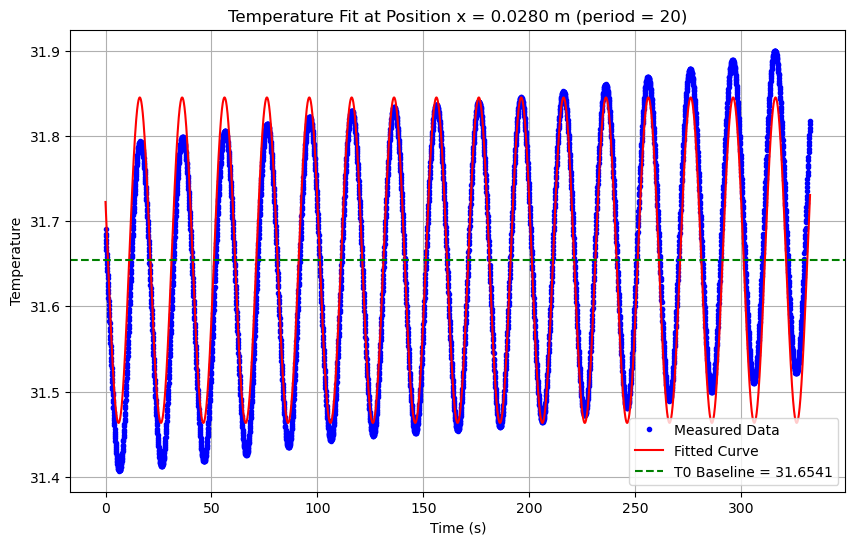


fitting the 7 thermometer（0.0330m)
fitting compelete - D = 0.00002195 ± 0.00000004 m²/s, C- = -0.002380 ± 0.000013, C+ = -1.945135+1.491253j ± 0.010973-0.008413j, T0 = 31.7073 ± 0.0005


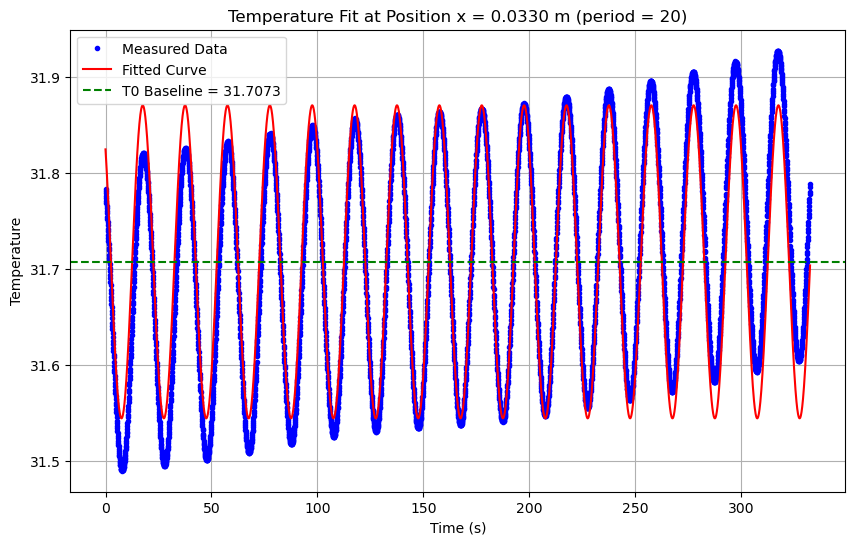


fitting the 8 thermometer（0.0380m)
fitting compelete - D = 0.00002040 ± 0.00000005 m²/s, C- = -0.002165 ± 0.000013, C+ = -1.766249+2.285412j ± 0.010674-0.013811j, T0 = 31.6270 ± 0.0005


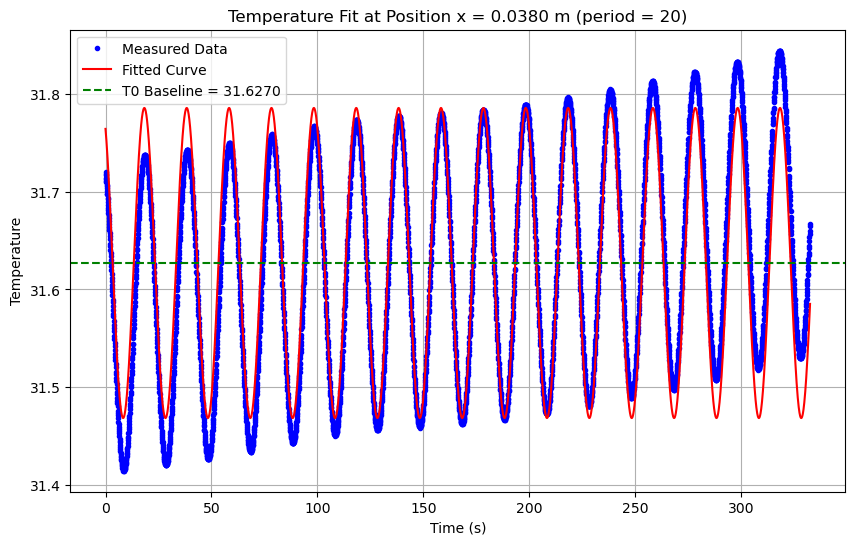


===== Fitting Results Statistics =====
D values at each position: ['0.00002507', '0.00002448', '0.00002449', '0.00002369', '0.00002343', '0.00002312', '0.00002195', '0.00002040']
Weighted average of D: 0.00002438 m²/s
T0 values at each position: ['31.7279', '31.6896', '31.6713', '31.6312', '31.6853', '31.6541', '31.7073', '31.6270']
Weighted average of T0: 31.6671


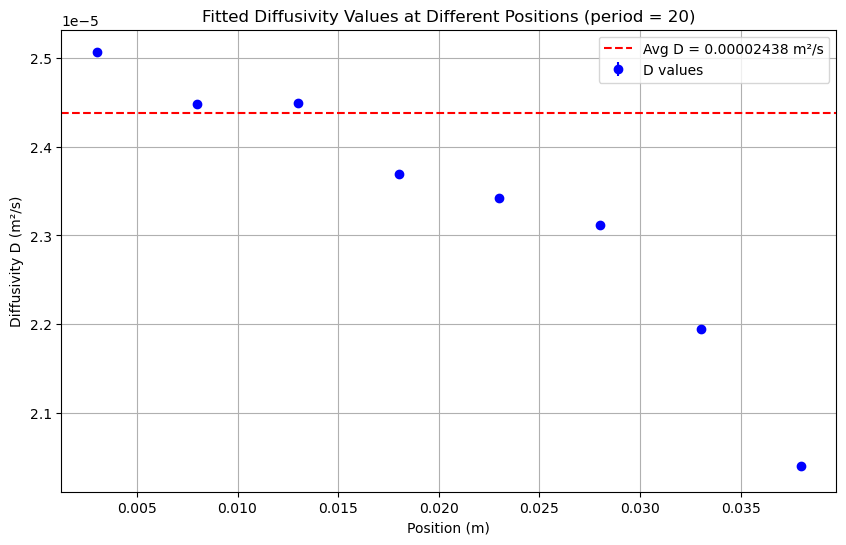


Final average D = 0.00002438 m²/s

Unweighted average D = 0.00002333 m²/s
Final average baseline temperature T0 = 31.6671


In [174]:
period =20
omega = 2*np.pi/period 
if __name__ == "__main__":
    
    timestamp, output_voltage, output_current, thermistor_temperatures = (
        load_dataset("../data/brass data/brass 20s.csv")
    )
    
    positions = calculate_positions()
    
    results = fit_diffusivity(timestamp, thermistor_temperatures, positions)
    
    average_results = analyze_results(results)
    
    if average_results:
        print(f"\nFinal average D = {average_results['D_avg']:.8f} m²/s")
        print(f"\nUnweighted average D = {average_results['D_avg_unweighted']:.8f} m²/s")
        print(f"Final average baseline temperature T0 = {average_results['T0_avg']:.4f}")